In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao


In [2]:
# GridWorld

ALPHA_Q = 0.9
ALPHA_TLR = 0.001
GAMMA = 0.99
E = 50_000
H = 5
EPS = 1.0
EPS_DECAY = 0.9999
K = 8
SCALE = 0.1

ENV = GridWorldEnv()

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

In [113]:


fhq_learner = FHQLearning(DISCRETIZER, ALPHA_Q, H)

_ = run_experiment(0, E, H, EPS, EPS_DECAY, ENV, fhq_learner)

mat_q = np.max(fhq_learner.Q, axis=3)[0].reshape(ENV.W, ENV.W)



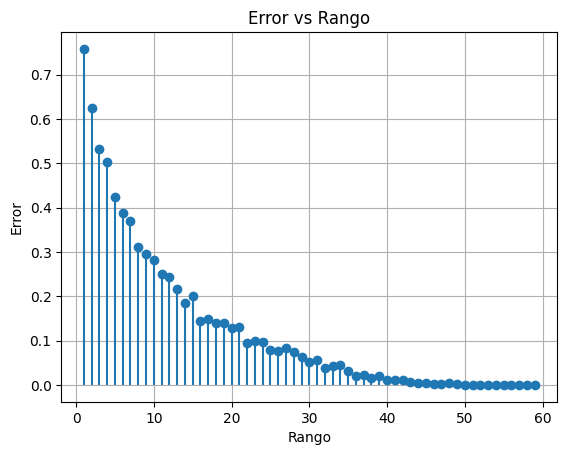

In [4]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(fhq_learner.Q, "P1")

In [3]:
# Creamos la función Q
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )

In [9]:
nS = ENV.nS
nA = ENV.nA
W = ENV.W
R = ENV.R
P = ENV.P

bp_learner = BackwardPropagation(H,nS,nA,R,P)
fpi_learner = FrontPolicyImprovement(H,nS,nA,R,P)
bpi_learner = BackPolicyImprovement(H,nS,nA,R,P)

_ = bp_learner.run()
_, error_fpi = fpi_learner.run()
_, error_bpi = bpi_learner.run()

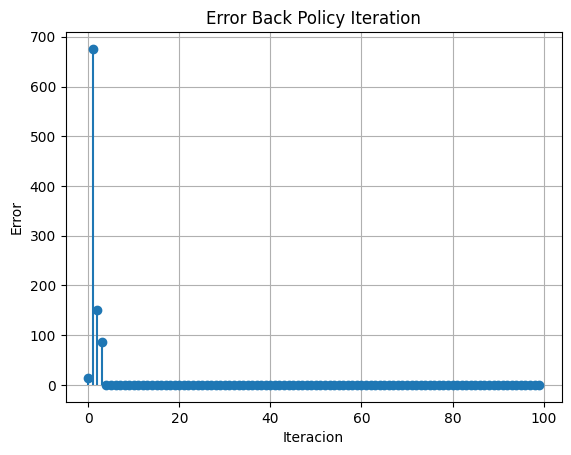

In [107]:
plt.stem(error_fpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


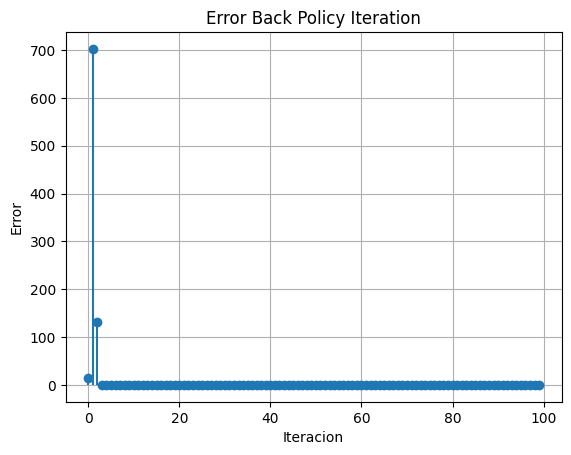

In [108]:
plt.stem(error_bpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


BACKGUARDS INDUCTION

In [85]:
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
R_sa = np.sum(np.multiply(R, P),axis=0)
for h in range(1,H+1):
    if h == 1:
        Q[H-h,:,:] = R_sa
    else:
        Q[H-h,:,:] = R_sa + np.sum((P*np.max(Q[H-(h-1),:,:], axis=1)[:,np.newaxis,np.newaxis]),axis=0)

Q_BP = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_BP[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_BP))

In [102]:
Q_reshape = np.zeros(
    np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
)
for h in range(H):
    for nA, a in enumerate(product(*[ np.arange(0,da) for da in discretizer.bucket_actions])):
        Q_reshape [h,...,a] = np.transpose(Q[h,:,nA].reshape(*discretizer.bucket_states))


In [103]:
print(np.linalg.norm(Q_reshape[:,:,:,:]-Q_BP[:,:,:,:]))

0.0


POLICY ITERATION

In [10]:
R_sa = np.sum(np.multiply(R, P),axis=0)
P_sa_s = np.transpose(P, (1, 2, 0))
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
def policy_evaluation1(Pi):
    V = np.zeros((H,nS))
    for _ in range(100):
        for h in range(H):
            P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[h,:])
            R_s = np.einsum('ij, ij -> i', R_sa, Pi[h,:])
            V[h,:] = R_s
            if h < H-1 :
                V[h,:] += P_s_s @ V[h+1,:]
        
    Q = np.roll((R_sa[:,:,np.newaxis] +P_sa_s @ np.transpose(V)), shift=-1, axis=2)
    Q[:,:,H-1] = R_sa
    return V, np.transpose(Q,(2,0,1))

def policy_evaluation2(Pi):
    V = np.zeros((H,nS))
    R_h_sa = np.zeros((H,nS,nA))
    for h in range(1,H+1):
        P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[H-h,:])
        R_s = np.einsum('ij, ij -> i', R_sa, Pi[H-h,:])
        if h == 1:
            V[H-h,:] = R_s
        else:
            V[H-h,:] = R_s + P_s_s @ V[H-(h-1),:]
    for h in range(H):
        if h == H-1:
            Q[h,:,:] = R_sa
        else:
            Q[h,:,:] = R_sa +P_sa_s @ V[h+1,:]  
    return V, Q


def policy_improvement(Q):
    Pi = np.zeros((H,nS, nA))
    for h in range(H):
        for s in range(nS):
            a = np.argmax(Q[h, s, :])
            Pi[h,s, a] = 1
    return Pi

V_old = np.zeros((H,nS))
Q_old = np.zeros((H,nS, nA))
Pi = np.random.rand(H,nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(100):
    V, Q = policy_evaluation1(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V
Q_policy = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_policy[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

In [11]:
print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_policy[:,:,:,:]))

0.01019446942482654


DESCOMPOSICIÓN Y BCD

In [ ]:
k = 8
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = PARAFAC(
    np.concatenate(
        [[H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= 0.1,
    nA=len(discretizer.bucket_actions),
).double()

Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)*10

for factor in Q.factors:
    print(factor.shape)

reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
#print(reconstructed_tensor)
#factors =  parafac(fhq_learner.Q, rank=20)
#print(factors.weights)

torch.Size([5, 8])
torch.Size([25, 8])
torch.Size([4, 8])


5

In [ ]:
def policy_improvement(Q):


In [ ]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh
r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
r_gorro = np.tile(r, (ENV.H, 1)).reshape(-1)
errors = []
for i in range(1000) :
    Pi = np.zeros((H,nS, nA))
    Q_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
    for h in range(H):
        for s in range(nS):
            a = np.argmax(Q_tensor[h, s, :])
            Pi[h,s, a] = 1

    H = Q.factors[0]
    A = Q.factors[1+len(discretizer.bucket_states):][0]
    S = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]

    S_i = np.matmul(np.linalg.pinv(calculate_Ds(S, A, H, ENV, Pi)), r_gorro).reshape(ENV.nS,k)
    A_i = np.matmul(np.linalg.pinv(calculate_Da(S, A, H, ENV, Pi)), r_gorro).reshape(ENV.nA,k)
    H_i = np.matmul(np.linalg.pinv(calculate_Dh(S, A, H, ENV, Pi, k)), r_gorro).reshape(ENV.H,k)
    error =  np.linalg.norm(S.detach().numpy()-S_i) + np.linalg.norm(A.detach().numpy()-A_i) + np.linalg.norm(H.detach().numpy()-H_i)
    errors.append(error)
    if error < 0.1:
        break

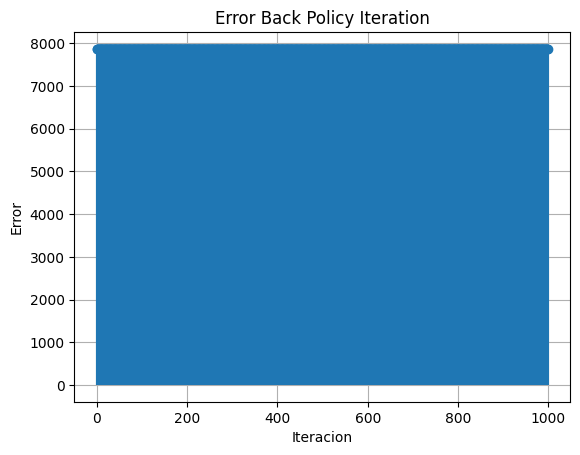

In [24]:
plt.stem(errors, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()

In [4]:
P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)
Pi /= Pi.sum(axis=1, keepdims=True)
Pi_h = Pi[0,:]
print(Pi_h.shape)
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)

P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
for nSnA in range(ENV.nS*ENV.nA):
    P_sa_sa[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)

print(P_sa_sa.shape)

(25, 4)
(100, 100)


In [41]:
norm = []
P1 = []
r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
Q_h = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
for h in range(H):
    if h < H-1:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        norm.append(np.linalg.norm(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1)))
        P1.append(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1))
    else:
        norm.append(np.linalg.norm(r-Q_h[h,:].reshape(-1)))
        P1.append(r-Q_h[h,:].reshape(-1))

print(norm)

[158.11041465645624, 158.1173850153215, 158.11225468115413, 158.11231182084762, 158.11371783885673]


In [38]:
P1

[array([-9.35585851e-04,  2.99515139e-04, -1.09230905e-03,  5.29164496e-04,
         3.02759821e-03,  4.99966549e+01,  5.29373341e-03,  4.54473555e-03,
         5.40597088e-03,  7.48452721e-03, -4.62438190e-03, -7.74180906e-03,
         2.99275353e-03,  3.25979226e-03, -5.61399893e-03, -1.28975081e-02,
         1.58771670e-03, -4.81866192e-03, -6.48110493e-03,  3.21422281e-03,
         4.99911862e+01, -6.45504051e-03,  8.32024088e-03,  9.54006626e-03,
        -1.59568079e-03,  6.66255581e-03, -5.46969051e-03, -1.20427205e-02,
         1.19929353e-03,  1.19955266e-03, -3.12633560e-03, -8.64047565e-05,
         7.80675802e-03, -8.09024677e-03, -4.38436716e-03,  1.36257166e-02,
        -2.53812425e-04, -3.01720710e-03,  5.60722729e-03,  1.56100196e-05,
        -4.77377775e-03,  4.51485496e-03,  8.94669634e-03, -6.24009417e-03,
        -2.08436336e-03, -6.60332253e-03,  5.63618075e-03,  5.30348585e-03,
         6.64087091e-03, -1.96825074e-03, -1.18925510e-02, -3.88943048e-03,
         3.8

In [6]:
print(Q_h[h,:].shape)
print(np.sum(np.multiply(ENV.R, ENV.P),axis=0).shape)
print(P_pi_h.shape)

(25, 4)
(25, 4)
(100, 100)


In [7]:
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
H = ENV.H

H_t = Q.factors[0]
A_t = Q.factors[1+len(discretizer.bucket_states):][0]
S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]


In [8]:
s = S_t.reshape(-1)
I_s = torch.eye(S_t.shape[0])
Ds_h = []
for h in range(H):
    if h == H -1:
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_s,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])))
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(X-Y)

Ds = np.vstack(Ds_h)

In [33]:
print(Ds.shape)
print(Ds_h[0].shape)
print(np.tile(r, (ENV.H, 1)).reshape(-1).shape)
print(np.matmul(Ds,(S_t).reshape(-1).detach().numpy()).shape)
print((S_t).reshape(-1).detach().numpy().shape)
print(np.matmul(Ds_h[0],(S_t).reshape(-1).detach().numpy()).shape)

(500, 500)
(100, 500)
(500,)
(500,)
(500,)
(100,)


In [42]:
np.hstack(P1)-np.hstack(a)

array([ 1.19262239e-18,  5.42101086e-20,  0.00000000e+00,  1.19262239e-18,
        4.33680869e-19, -7.10542736e-15,  0.00000000e+00,  2.60208521e-18,
       -8.67361738e-19,  8.67361738e-19,  0.00000000e+00,  0.00000000e+00,
        4.33680869e-19,  4.33680869e-19, -8.67361738e-19, -3.46944695e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.67361738e-19,
        0.00000000e+00,  1.73472348e-18,  0.00000000e+00,  0.00000000e+00,
       -2.16840434e-19, -1.73472348e-18,  1.73472348e-18, -1.73472348e-18,
        1.95156391e-18, -4.33680869e-19, -1.73472348e-18,  1.46367293e-18,
       -1.73472348e-18,  0.00000000e+00,  8.67361738e-19,  0.00000000e+00,
       -1.08420217e-19,  4.33680869e-19,  1.73472348e-18, -1.95156391e-18,
        0.00000000e+00,  0.00000000e+00, -1.73472348e-18,  8.67361738e-19,
       -4.33680869e-19,  0.00000000e+00,  8.67361738e-19, -8.67361738e-19,
        1.73472348e-18, -4.33680869e-19,  1.73472348e-18,  1.30104261e-18,
        0.00000000e+00,  

In [36]:
norm = []
a = []
for Dsh in Ds_h:
    a.append(r + np.matmul(Dsh,(S_t).reshape(-1).detach().numpy()))
    norm.append(np.linalg.norm(r + np.matmul(Dsh,(S_t).reshape(-1).detach().numpy()),ord=2))
print(np.linalg.norm(np.hstack(a),ord=2))
print(norm)
print(np.sum(np.array(norm)))

print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(np.vstack(Ds_h),(S_t).reshape(-1).detach().numpy()),ord=2))

353.5519009501104
[158.11041465645624, 158.11738501532153, 158.11225468115413, 158.11231182084762, 158.11371783885673]
790.5660840126362
353.5519009501104


In [28]:
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Ds,(np.transpose(S_t.detach().numpy())).reshape(-1))))

353.55688000170824


In [148]:
a = A_t.reshape(-1)
I_a = torch.eye(A_t.shape[0])
Da_h = []
for h in range(H):
    if h == H-1:
        Y =  np.kron(I_a,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), S_t.detach().numpy()]))
        Da_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_a,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), S_t.detach().numpy()])))
        Y =  np.kron(I_a,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), S_t.detach().numpy()]))
        Da_h.append(X-Y)

Da = np.vstack(Da_h)
            

In [149]:
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,A_t.reshape(-1).detach().numpy())))

353.55879784254864


In [63]:
H_t.shape

torch.Size([5, 20])

In [150]:
k = 20
h = H_t.reshape(-1)
I_h = torch.eye(A_t.shape[0])
Dh_h = []

M_h_h = []
for h in range(H):
    Mh = np.zeros((k, ENV.H*k))
    Mh[:, h*k:(h+1)*k] = np.eye(k) 
    M_h_h.append(Mh)

for h in range(H):
    if h == H-1:
        Y = np.matmul(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]),M_h_h[h])
        Dh_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(np.matmul(P_pi_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])),M_h_h[h+1])
        Y = np.matmul(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]),M_h_h[h])
        Dh_h.append(X-Y)

Dh = np.vstack(Dh_h)

In [151]:
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,H_t.reshape(-1).detach().numpy())))

353.55879784254864


In [153]:
for n in range(1000):
    np.linalg.pinv(A)
    H_t = Q.factors[0]
    A_t = Q.factors[1+len(discretizer.bucket_states):][0]
    S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]



SyntaxError: invalid syntax (2936027638.py, line 1)

In [42]:
len(M_h_h)

4

In [31]:
print(P_pi_h.shape)
print(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]).shape)
print(np.matmul(P_pi_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])).shape)
print(M_h_h[h+1].shape)


(100, 100)
(100, 20)
(100, 20)
(20, 100)


In [ ]:
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
H = ENV.H

H_t = Q.factors[0]
A_t = Q.factors[1+len(discretizer.bucket_states):][0]
S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]


s = S_t.reshape(-1)
I_s = torch.eye(S_t.shape[0])
Ds_h = []
for h in range(H-1):
    if h == H :
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_s,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])))
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(X-Y)

Ds = np.vstack(Ds_h)
            


In [77]:
np.kron(I_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])).shape

(2000, 400)

In [52]:
Da.shape

(400, 80)

In [20]:
khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]).shape

(4, 20)

In [19]:
np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()])).shape

(20, 100)

In [17]:

print((H_t[h+1].detach().numpy().reshape(1,-1)).shape)
print((A_t.detach().numpy()).shape)
K = khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])
print(K.shape)


(1, 20)
(4, 20)
(4, 20)


In [119]:
Empezar por la P luego ver que los katries estan saliendo bien

TypeError: 'int' object is not subscriptable

In [34]:
P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)
Pi /= Pi.sum(axis=1, keepdims=True)
Pi_h = Pi[0,:]
print(Pi_h.shape)
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
for nSnA in range(ENV.nS*ENV.nA):
    print(Pi_h)
    print(P_sa_s[nSnA,:])
    print((Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1))

(25, 4)
[[2.42402666e-02 3.99568503e-02 2.09673365e-03 2.19900974e-02]
 [3.65233947e-02 4.65448383e-02 2.35231977e-02 8.24230834e-02]
 [3.32610454e-02 4.40178960e-02 2.39281658e-02 3.94235424e-02]
 [4.05325760e-02 5.44639777e-02 6.63593691e-02 5.01519558e-02]
 [6.14697409e-02 3.81846146e-02 5.12919273e-02 7.72066626e-02]
 [7.10874448e-02 5.51534962e-02 8.66536049e-03 4.53653939e-02]
 [2.35139667e-02 5.13513541e-02 6.65588844e-02 3.26352591e-02]
 [7.05660835e-02 5.63424680e-02 3.12371600e-02 1.61063709e-02]
 [1.50176696e-02 4.68899622e-02 3.16390321e-02 7.71694406e-03]
 [1.25115853e-03 6.36328107e-02 4.98055510e-02 6.86767504e-02]
 [6.70951807e-02 2.57326818e-02 6.44674887e-02 2.61243973e-02]
 [2.04314810e-02 3.03650913e-02 6.04656775e-02 3.60146280e-02]
 [7.31778347e-02 5.61812517e-02 5.00585374e-02 4.01177894e-02]
 [3.10917193e-03 2.44355475e-02 6.61776498e-02 6.65325203e-02]
 [1.92372664e-03 5.21908611e-02 3.91904320e-02 1.32154078e-02]
 [6.96102633e-02 1.72061704e-03 6.18677637e-02 

In [66]:
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
nSnA = 26
print(Pi_h)
print(P_sa_s[nSnA,:])
print((Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)))

[[0.0374859  0.01967566 0.07839676 0.06429829]
 [0.06655328 0.00485288 0.06480497 0.07219572]
 [0.03117632 0.01292299 0.05951244 0.05497526]
 [0.04489768 0.07500942 0.05921149 0.04457135]
 [0.04250435 0.01094818 0.07810497 0.0467048 ]
 [0.06554252 0.06580799 0.00152401 0.03393827]
 [0.00460365 0.03263643 0.03487418 0.009645  ]
 [0.01542692 0.03223038 0.00691806 0.046788  ]
 [0.0428137  0.04100617 0.06116143 0.05473401]
 [0.06681055 0.02234742 0.00887144 0.07361109]
 [0.03893672 0.01452172 0.01344844 0.01717865]
 [0.03485775 0.02048261 0.02020843 0.05847526]
 [0.05754919 0.06217472 0.04385475 0.02212435]
 [0.05429722 0.02337564 0.03821061 0.03291125]
 [0.00689884 0.07434554 0.03361637 0.02833742]
 [0.04751614 0.04324297 0.02212334 0.00937709]
 [0.0555696  0.05751359 0.04544588 0.05962072]
 [0.04962236 0.01929291 0.03403781 0.04134607]
 [0.03047242 0.07118936 0.03804479 0.05982171]
 [0.02131086 0.05777019 0.05871883 0.02688267]
 [0.06157174 0.05285506 0.03041749 0.02457686]
 [0.01129563 

In [56]:
import numpy as np

# Vector fila
vector = np.array([[2, 3, 4, 5],[2, 3, 4, 5]])

# Matriz
matrix = np.array([[10, 20, 30, 40],
                   [50, 60, 70, 80]])

# Multiplicación elemento a elemento por filas
result = matrix * vector[0,:]

print("Resultado:\n", result)



Resultado:
 [[ 20  60 120 200]
 [100 180 280 400]]


In [101]:
(torch.kron(I_s,H_t[h+1]*A_t)).shape

torch.Size([20, 100])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


[[[[-3.04385356e-05 -2.58577966e-04  3.17866157e-04  3.31131961e-05]
   [-1.16286508e-04 -1.73684132e-04 -2.30767625e-04  2.38884554e-04]
   [-8.45154085e-04  2.93043994e-04 -4.08599464e-04 -3.80038361e-05]
   [-2.77142557e-04  5.32853111e-05  1.89730437e-04  3.22431727e-04]
   [-9.95723544e-04  2.69971838e-04 -3.66472833e-04  5.15901306e-04]]

  [[-1.65034809e-04 -7.96098380e-05  2.29879364e-05 -3.38377822e-05]
   [ 6.43870834e-04  8.64052473e-05 -7.41923677e-04 -1.96259221e-04]
   [ 2.39728211e-04  3.20068001e-04  3.72394443e-04  7.21298471e-04]
   [-2.70212816e-04  1.97970058e-04  4.70435279e-04 -3.29862380e-04]
   [-1.94604476e-04  3.19081276e-04  8.44841717e-05 -2.37604150e-04]]

  [[ 3.65220485e-04 -1.68260817e-04  1.58777272e-04  5.75653608e-04]
   [-3.11555155e-04  1.87380751e-04 -1.33528916e-04  2.99731287e-04]
   [ 6.42792552e-05  2.21658476e-04 -5.19410345e-04 -1.24819364e-03]
   [ 3.25087829e-05  9.71541843e-05  1.20360126e-04 -4.48978629e-04]
   [-3.64666847e-04  4.7853411